In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")

from convsklearn import barrier_trainer, asian_trainer
from feature_collector import collect_features, preprocess_data
price_name = 'barrier_price' 
trainer = barrier_trainer
data_dir = os.path.join(root,ms.cboe_spx_barriers['dump'])
dataset = collect_features(data_dir,price_name)
dataset
dates = dataset['calculation_date'].copy().squeeze().drop_duplicates().reset_index(drop=True)


##################
# training start #
##################

Fri Nov  1 17:02:41 2024



100%|█████████████████████████████████████████████████████████████████████████████| 2110/2110 [00:18<00:00, 117.00it/s]


158 140


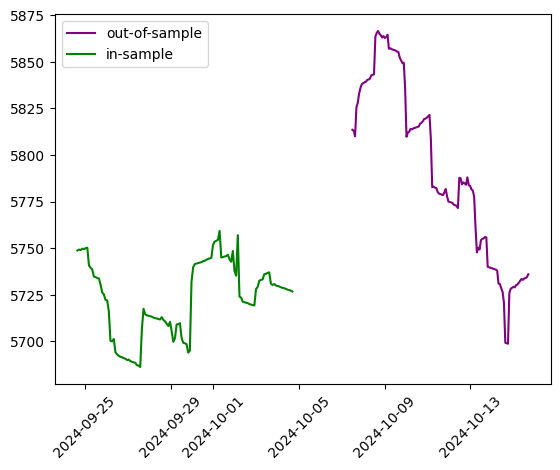

329696 329696


In [2]:
days = dates.dt.round('D').drop_duplicates()
latest = days.iloc[:10]
ante = days.iloc[10:19]
nspots=1
development_dates = dates[dates.dt.normalize().isin(ante)]#.iloc[-nspots:]
test_dates = dates[dates.dt.normalize().isin(latest)]#.iloc[:nspots]
print(len(development_dates),len(test_dates))
preprocessed = preprocess_data(dataset,development_dates,test_dates,trainer)

## stacked regressor

In [ ]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, PowerTransformer,FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
trainer.dnn_params['max_iter'] = 1000
trainer.dnn_params

In [ ]:
numerical_scaler = StandardScaler()
linear_contributors = [
    'spot_price', 'strike_price', 'days_to_maturity', 
    'risk_free_rate', 'dividend_rate', 'barrier',
    'v0',
    'theta',
    'kappa',
]

ridge_preprocessor = ColumnTransformer(
    transformers=[('scaling', numerical_scaler,linear_contributors)]
)

ridge_pipeline = make_pipeline(ridge_preprocessor, RidgeCV())

test_ridge = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    transformer=numerical_scaler
)

test_ridge_fit = test_ridge.fit(train_X,train_y)

In [ ]:
K = train_X['strike_price'].squeeze().reset_index(drop=True).to_numpy()

predictions = test_ridge_fit.predict(train_X)
diff = predictions-train_y
fig,axs = plt.subplots(2,figsize=(5,5),sharex=True)
axs[0].scatter(K,predictions,s=0.1)
axs[0].set_title('prediction')
axs[1].scatter(K,diff,s=0.1)
axs[1].set_title('absolute prediction error')
plt.xlabel('strike price_name')
plt.show()
spots = train_data['spot_price'].copy().squeeze().sort_values().reset_index(drop=True)
spots.index = train_data['calculation_date']
print(f"\ntrain spots:\n{spots.drop_duplicates()}")
test_ridge

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_scaler,trainer.numerical_features),
        ('categorical',OneHotEncoder(),trainer.categorical_features)
    ]
)

mlp_pipeline = make_pipeline(preprocessor,MLPRegressor(**trainer.dnn_params))
stacked_regressor = StackingRegressor(estimators=[('dnn',mlp_pipeline),('ridge',ridge_pipeline)],final_estimator=GradientBoostingRegressor())
meta = TransformedTargetRegressor(regressor=stacked_regressor,transformer=numerical_scaler)
print(meta)

## testing specification

### versus original